In [12]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import chart_studio.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

In [4]:
df = pd.read_csv('consumer_complaints.csv')
df.head(1)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,08/09/2015,Credit reporting,NaN,Incorrect information on credit report,Information is not mine,NaN,Company chooses not to provide a public response,Experian Information Solutions Inc.,NJ,08872,NaN,Consent not provided,Web,08/09/2015,Closed with non-monetary relief,Yes,No,1509954.0


In [5]:
df2 = df[["Product","Consumer complaint narrative"]]
df2.head()

,Product,Consumer complaint narrative
0,Credit reporting,NaN
1,"Credit reporting, credit repair services, or o...",NaN
2,Debt collection,NaN
3,Mortgage,NaN
4,Credit card,I am dissatisfied with the current outcome of ...


In [6]:
df2 = df2.dropna()
df2.head()

,Product,Consumer complaint narrative
4,Credit card,I am dissatisfied with the current outcome of ...
8,"Credit reporting, credit repair services, or o...",On XX/XX/18 an item showed up on my credit rep...
9,Debt collection,Saw on my credit report that there is a collec...
10,"Credit reporting, credit repair services, or o...",Capital one auto finacing XX/XX/2018 unknown i...
12,Credit card or prepaid card,I own a small trucking company. One of my truc...


In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39963 entries, 4 to 125854
Data columns (total 2 columns):
Product                         39963 non-null object
Consumer complaint narrative    39963 non-null object
dtypes: object(2)
memory usage: 936.6+ KB


In [8]:
df2.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    10418
Debt collection                                                                  9074
Mortgage                                                                         4838
Credit reporting                                                                 3051
Credit card or prepaid card                                                      2349
Student loan                                                                     2198
Credit card                                                                      1935
Bank account or service                                                          1522
Checking or savings account                                                      1489
Consumer Loan                                                                     914
Money transfer, virtual currency, or money service                                606
Vehicle loan or lease                                 

In [9]:
df2.loc[df2['Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
df2.loc[df2['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
df2.loc[df2['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
df2.loc[df2['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'
df2 = df2[df2.Product != 'Other financial service']

In [13]:
df2['Product'].value_counts().sort_values(ascending=False).iplot(kind='bar', yTitle='Number of Complaints', 
                                                                title='Number complaints in each product')

In [14]:
def print_plot(index):
    example = df2[df2.index == index][['Consumer complaint narrative', 'Product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])

In [24]:
print_plot(10)

Capital one auto finacing XX/XX/2018 unknown inquiring on credit report.
Product: Credit reporting, credit repair services, or other personal consumer reports


In [25]:
df2.head()

,Product,Consumer complaint narrative
4,Credit card or prepaid card,I am dissatisfied with the current outcome of ...
8,"Credit reporting, credit repair services, or o...",On XX/XX/18 an item showed up on my credit rep...
9,Debt collection,Saw on my credit report that there is a collec...
10,"Credit reporting, credit repair services, or o...",Capital one auto finacing XX/XX/2018 unknown i...
12,Credit card or prepaid card,I own a small trucking company. One of my truc...


In [26]:
df2 = df2.reset_index(drop=True)

In [27]:
df2.head()

,Product,Consumer complaint narrative
0,Credit card or prepaid card,I am dissatisfied with the current outcome of ...
1,"Credit reporting, credit repair services, or o...",On XX/XX/18 an item showed up on my credit rep...
2,Debt collection,Saw on my credit report that there is a collec...
3,"Credit reporting, credit repair services, or o...",Capital one auto finacing XX/XX/2018 unknown i...
4,Credit card or prepaid card,I own a small trucking company. One of my truc...


In [28]:
df2 = df2.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df2['Consumer complaint narrative'] = df2['Consumer complaint narrative'].apply(clean_text)

In [29]:
df2['Consumer complaint narrative'] = df2['Consumer complaint narrative'].str.replace('\d+', '')

In [30]:
print_plot(10)

 son received check social security settlement claim since income checking accountthe plan deposit check account start new account another bank endorsed check deposited check atm bank procedure take net day check cleari aware looked account  deposit note attached depositi called banks help line given different ecuses nt deposit check first ecuse son account second teller witness signing check flies face banks trying customer use many electronic devices possible years old today veteran served country taught deal checks internet big fail lack money caused severe hardship family food need pay bills contention wells fargo acted bad faith justly punished
Product: Bank account or service


In [31]:
print_plot(100)

sent letter third party collection agency perfection collection ut asking cease collection activity remove records credit report regarding account # c purchased asked provide evidence account could delete information furnished every one reports unverified information said company responded request sending contract list name customer coborrower fact signature spaces provided customer signature fact person whose signature recorded contract two separate signature lines customer sales person feel verification entered contract neither perfection collection unverified law required remove information credit report yet fact added another collection reports company larger amount
Product: Debt collection


In [32]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df2['Consumer complaint narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 40861 unique tokens.


In [33]:
X = tokenizer.texts_to_sequences(df2['Consumer complaint narrative'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (39930, 250)


In [34]:
X

array([[   0,    0,    0, ...,  139, 3863, 2102],
       [   0,    0,    0, ...,   68,    4,  153],
       [   0,    0,    0, ...,  814, 1533,    8],
       ...,
       [   0,    0,    0, ...,   17, 3688,   49],
       [   0,    0,    0, ...,  915,  847,    5],
       [   0,    0,    0, ..., 5595,  240,  639]])

In [35]:
Y = pd.get_dummies(df2['Product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (39930, 13)


In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(35937, 250) (35937, 13)
(3993, 250) (3993, 13)


In [37]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(13, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 100)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_1 (Dense)              (None, 13)                2613      
Total params: 5,163,413
Trainable params: 5,163,413
Non-trainable params: 0
_________________________________________________________________
None


In [38]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Instructions for updating:
Use tf.cast instead.
Train on 32343 samples, validate on 3594 samples
Epoch 1/5
32343/32343 [==============================] - 726s 22ms/step - loss: 1.3894 - acc: 0.5617 - val_loss: 1.2319 - val_acc: 0.6452
Epoch 2/5
32343/32343 [==============================] - 702s 22ms/step - loss: 1.0562 - acc: 0.6718 - val_loss: 0.9699 - val_acc: 0.6934
Epoch 3/5
32343/32343 [==============================] - 704s 22ms/step - loss: 0.8850 - acc: 0.7296 - val_loss: 0.8341 - val_acc: 0.7482
Epoch 4/5
32343/32343 [==============================] - 727s 22ms/step - loss: 0.7738 - acc: 0.7599 - val_loss: 0.7912 - val_acc: 0.7482
Epoch 5/5
32343/32343 [==============================] - 706s 22ms/step - loss: 0.8151 - acc: 0.7459 - val_loss: 0.8501 - val_acc: 0.7254


In [39]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

3993/3993 [==============================] - 90s 23ms/step
Test set
  Loss: 0.892
  Accuracy: 0.718


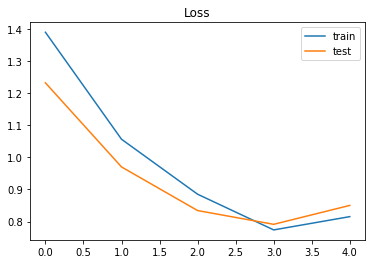

In [40]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

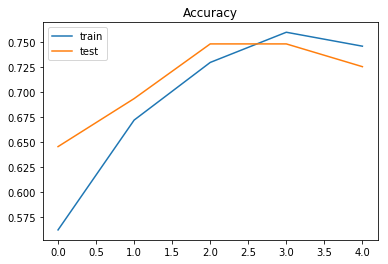

In [41]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [47]:
new_complaint = ['MPS/DELHI METRO/20170531154249/0']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(pred, labels[np.argmax(pred)])

[[0.04624222 0.05910565 0.13125998 0.11600488 0.10369994 0.24354985
  0.02654986 0.01735743 0.01235581 0.12056065 0.01147183 0.03027359
  0.08156825]] Bank account or service
